In [1]:
%matplotlib inline

# Analyze Visium fluorescence data

This tutorial shows how to apply Squidpy image analysis features for the
analysis of Visium data.

For a tutorial using Visium data that includes the graph analysis
functions, have a look at
`sphx_glr_auto_tutorials_tutorial_visium_hne.py`. The dataset used here
consists of a Visium slide of a coronal section of the mouse brain. The
original dataset is publicly available at the 10x genomics [dataset
portal](https://support.10xgenomics.com/spatial-gene-expression/datasets)
. Here, we provide a pre-processed dataset, with pre-annotated clusters,
in `anndata.AnnData` format and the tissue image in
`squidpy.im.ImageContainer` format.

A couple of notes on pre-processing:

> -   The pre-processing pipeline is the same as the one shown in the
>     original [Scanpy
>     tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html)
>     .
> -   The cluster annotation was performed using several resources, such
>     as the [Allen Brain
>     Atlas](https://mouse.brain-map.org/experiment/thumbnails/100048576?image_type=atlas)
>     , the [Mouse Brain gene expression atlas](http://mousebrain.org/)
>     from the Linnarson lab and this recent pre-print `linnarson2020`.

::: seealso
See `sphx_glr_auto_tutorials_tutorial_visium_hne.py` for additional
analysis examples.
:::

## Import packages & data

To run the notebook locally, create a conda environment as *conda env
create -f environment.yml* using this
[environment.yml](https://github.com/scverse/squidpy_notebooks/blob/main/environment.yml).


In [2]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import pandas as pd

import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

/home/ifichtner/anaconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8
squidpy==1.2.3


In [35]:
adata

AnnData object with n_obs × n_vars = 704 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'features_summary_cluster', 'features_histogram_cluster', 'features_texture_cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap', 'features_summary_cluster_colors', 'features_histogram_cluster_colors', 'features_texture_cluster_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'f

First, let\'s visualize the cluster annotation in the spatial context
with `squidpy.pl.spatial_scatter`.

As you can see, this dataset is a smaller crop of the whole brain
section. We provide this crop to make the execution time of this
tutorial a bit shorter.


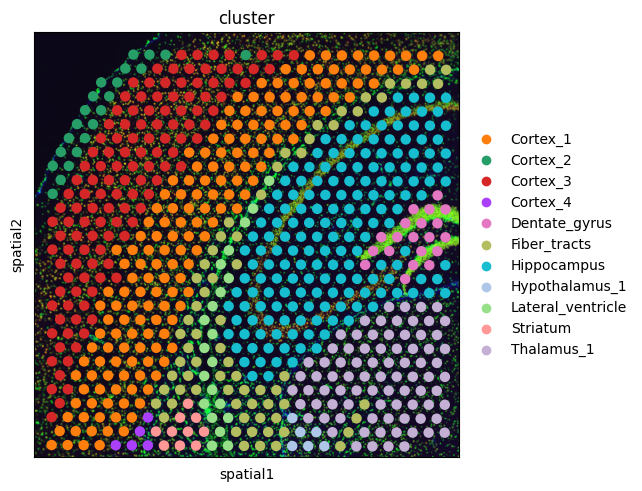

In [3]:
sq.pl.spatial_scatter(adata, color="cluster")

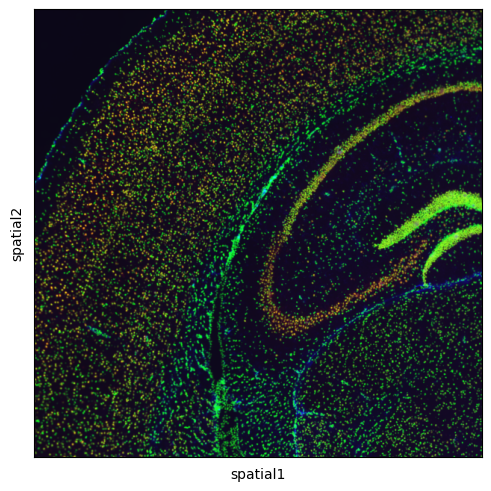

In [4]:
sq.pl.spatial_scatter(adata)

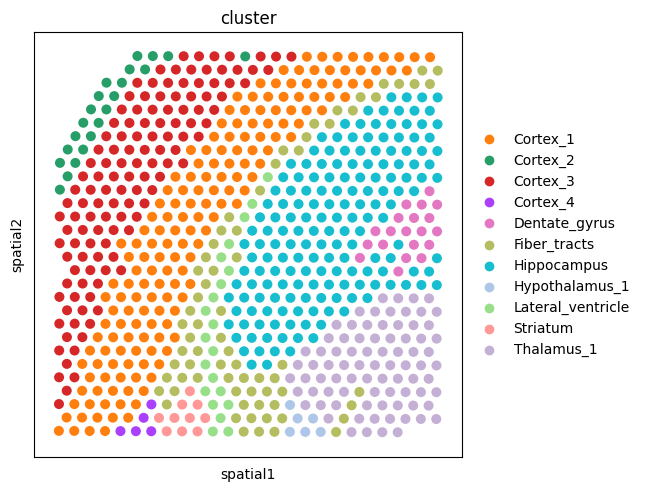

In [5]:
sq.pl.spatial_scatter(adata, color='cluster', img=False)

The fluorescence image provided with this dataset has three channels:
*DAPI* (specific to DNA), *anti-NEUN* (specific to neurons), *anti-GFAP*
(specific to Glial cells). We can directly visualize the channels with
the method `squidpy.im.ImageContainer.show`.


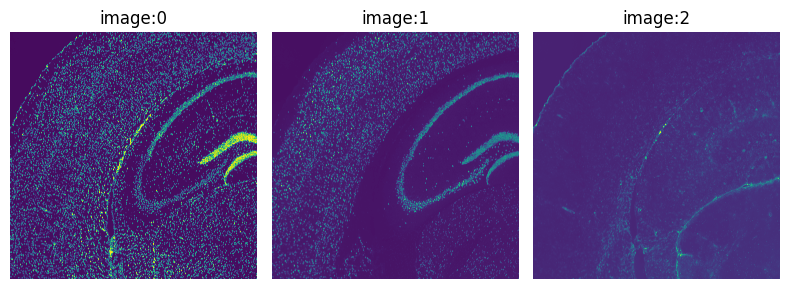

In [6]:
sq.im.ImageContainer.show(img, channelwise=True)

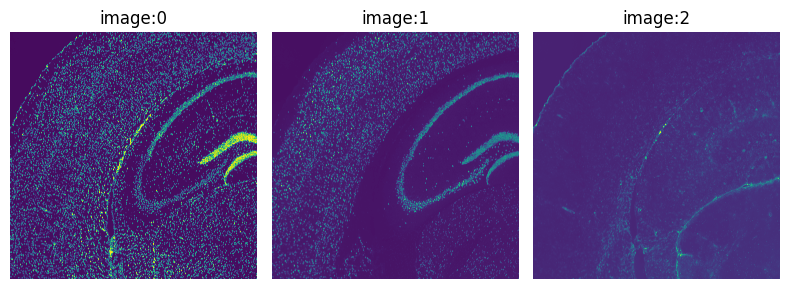

In [7]:
img.show(channelwise=True)

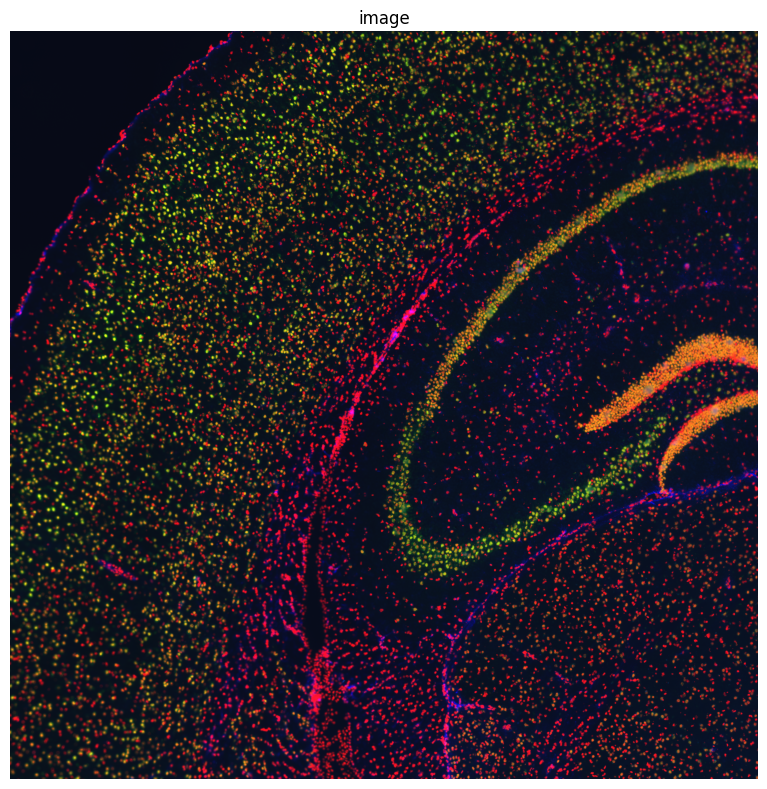

In [8]:
img.show()

Visium datasets contain high-resolution images of the tissue. Using the
function `squidpy.im.calculate_image_features` you can calculate image
features for each Visium spot and create a `obs x features` matrix in
`adata` that can then be analyzed together with the `obs x gene` gene
expression matrix.

By extracting image features we are aiming to get both similar and
complementary information to the gene expression values. Similar
information is for example present in the case of a tissue with two
different cell types whose morphology is different. Such cell type
information is then contained in both the gene expression values and the
tissue image features. Complementary or additional information is
present in the fact that we can use a nucleus segmentation to count
cells and add features summarizing the immediate spatial neighborhood of
a spot.

Squidpy contains several feature extractors and a flexible pipeline of
calculating features of different scales and sizes. There are several
detailed examples of how to use `squidpy.im.calculate_image_features`.
`sphx_glr_auto_examples_image_compute_features.py` provides a good
starting point for learning more.

Here, we will extract [summary]{.title-ref}, [histogram]{.title-ref},
[segmentation]{.title-ref}, and [texture]{.title-ref} features. To
provide more context and allow the calculation of multi-scale features,
we will additionally calculate [summary]{.title-ref} and
[histogram]{.title-ref} features at different crop sizes and scales.

# Image segmentation

To calculate [segmentation]{.title-ref} features, we first need to
segment the tissue image using `squidpy.im.segment`. But even before
that, it\'s best practice to pre-process the image by e.g. smoothing it
using in `squidpy.im.process`. We will then use the *DAPI* channel of
the fluorescence image (`channel_id s= 0`). Please refer to
`sphx_glr_auto_examples_image_compute_segment_fluo.py` for more details
on how to calculate a segmented image.


In [9]:
img

ImageContainer[shape=(7272, 7272), layers=['image']]

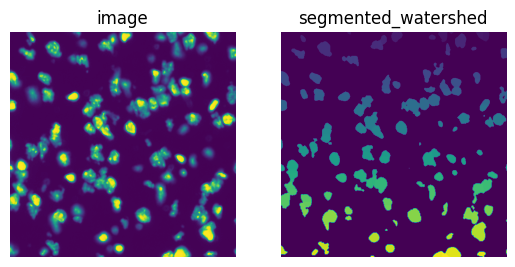

In [10]:
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
)

sq.im.segment(img=img, layer="image_smooth", method="watershed", channel=0, chunks=1000)

# plot the resulting segmentation
fig, ax = plt.subplots(1, 2)
img_crop = img.crop_corner(2000, 2000, size=500)
img_crop.show(layer="image", channel=0, ax=ax[0])
img_crop.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

In [11]:
img

ImageContainer[shape=(7272, 7272), layers=['image', 'image_smooth', 'segmented_watershed']]

> IDF: Why not show the entire image?

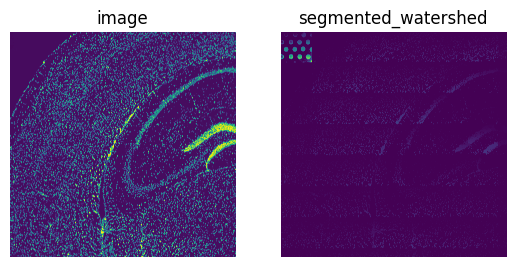

In [12]:
fig, ax = plt.subplots(1, 2)
img.show(layer="image", channel=0, ax=ax[0])
img.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

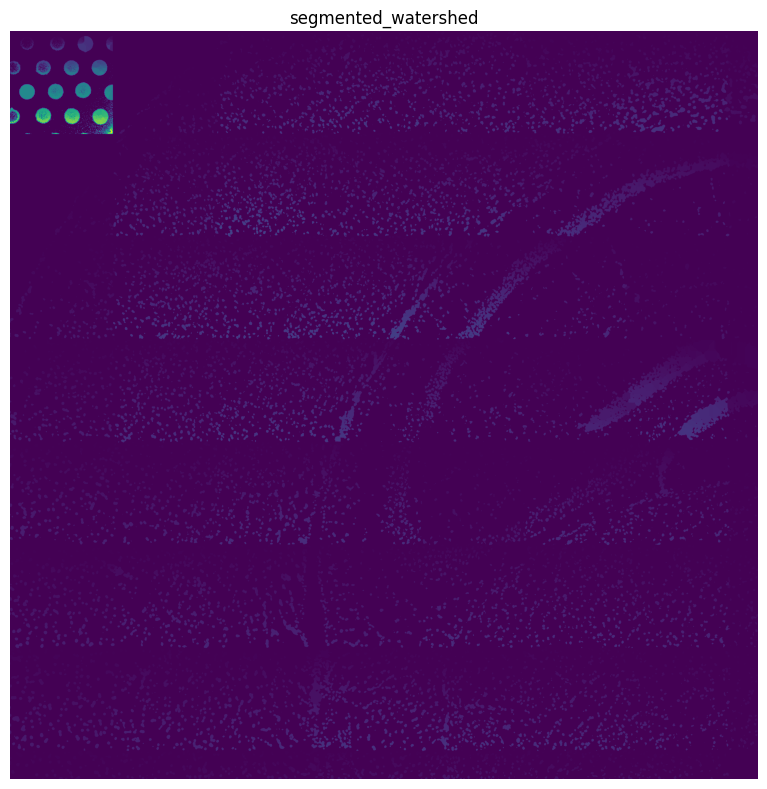

In [13]:
img.show(layer='segmented_watershed', channel=0)

The result of `squidpy.im.segment` is saved in
`img['segmented_watershed']` by default. It is a label image where each
segmented object is annotated with a different integer number.

# Segmentation features

We can now use the segmentation to calculate segmentation features.
These include morphological features of the segmented objects and
channel-wise image intensities beneath the segmentation mask. In
particular, we can count the segmented objects within each Visium spot
to get an approximation of the number of cells. In addition, we can
calculate the mean intensity of each fluorescence channel within the
segmented objects. Depending on the fluorescence channels, this can give
us e.g., an estimation of the cell type. For more details on how the
segmentation features, you can have a look at the docs of
`squidpy.im.calculate_image_features` or the example at
`sphx_glr_auto_examples_image_compute_segmentation_features.py`.


In [ ]:
# define image layer to use for segmentation
features_kwargs = {"segmentation": {"label_layer": "segmented_watershed"}}
# calculate segmentation features
sq.im.calculate_image_features(
    adata,
    img,
    features="segmentation",
    layer="image",
    key_added="features_segmentation",
    n_jobs=1,
    features_kwargs=features_kwargs,
)

In [15]:
adata

AnnData object with n_obs × n_vars = 704 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'features_segmentation'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [21]:
adata.obsm['features_segmentation']

segmentation_label  segmentation_area_mean  \
AAACGAGACGGTTGAT-1                  13              305.846154   
AAAGGGATGTAGCAAG-1                  29               70.482759   
AAATGGCATGTCTTGT-1                  25              160.920000   
AAATGGTCAATGTGCC-1                  14              227.785714   
AAATTAACGGGTAGCT-1                   9              238.111111   
...                                ...                     ...   
TTGTCGTTCAGTTACC-1                  24              574.750000   
TTGTGGCCCTGACAGT-1                  33              159.727273   
TTGTTAGCAAATTCGA-1                  36              170.388889   
TTGTTCAGTGTGCTAC-1                   7               58.428571   
TTGTTGTGTGTCAAGA-1                  19              219.473684   

                    segmentation_area_std  \
AAACGAGACGGTTGAT-1             319.319191   
AAAGGGATGTAGCAAG-1              51.630398   
AAATGGCATGTCTTGT-1             164.038756   
AAATGGTCAATGTGCC-1             173.923702   
AAATTAACGGGTAGCT-1             217.461846   
...                                   ...   
TTGTCGTTCAGTTACC-1             958.241586   
TTGTGGCCCTGACAGT-1             151.869616   
TTGTTAGCAAATTCGA-1             166.221452   
TTGTTCAGTGTGCTAC-1              51.160412   
TTGTTGTGTGTCAAGA-1             203.330783   

                    segmentation_ch-0_mean_intensity_mean  \
AAACGAGACGGTTGAT-1                           42433.260384   
AAAGGGATGTAGCAAG-1                           45053.132447   
AAATGGCATGTCTTGT-1                           28704.312828   
AAATGGTCAATGTGCC-1                           38614.407780   
AAATTAACGGGTAGCT-1                           38295.560915   
...                                                   ...   
TTGTCGTTCAGTTACC-1                           49838.600350   
TTGTGGCCCTGACAGT-1                           34702.432920   
TTGTTAGCAAATTCGA-1                           35952.108662   
TTGTTCAGTGTGCTAC-1                           44756.017606   
TTGTTGTGTGTCAAGA-1                           40494.353202   

                    segmentation_ch-0_mean_intensity_std  \
AAACGAGACGGTTGAT-1                           9884.597383   
AAAGGGATGTAGCAAG-1                          12147.549615   
AAATGGCATGTCTTGT-1                           5150.402963   
AAATGGTCAATGTGCC-1                           8714.135498   
AAATTAACGGGTAGCT-1                          10868.043866   
...                                                  ...   
TTGTCGTTCAGTTACC-1                          11097.817946   
TTGTGGCCCTGACAGT-1                           6555.460607   
TTGTTAGCAAATTCGA-1                           7469.405908   
TTGTTCAGTGTGCTAC-1                          11255.716475   
TTGTTGTGTGTCAAGA-1                           6693.582797   

                    segmentation_ch-1_mean_intensity_mean  \
AAACGAGACGGTTGAT-1                            7118.463335   
AAAGGGATGTAGCAAG-1                           12065.790898   
AAATGGCATGTCTTGT-1                           12998.823133   
AAATGGTCAATGTGCC-1                            3715.546297   
AAATTAACGGGTAGCT-1                            9168.584853   
...                                                   ...   
TTGTCGTTCAGTTACC-1                            3887.443495   
TTGTGGCCCTGACAGT-1                           12485.224347   
TTGTTAGCAAATTCGA-1                           19945.755806   
TTGTTCAGTGTGCTAC-1                            4609.843252   
TTGTTGTGTGTCAAGA-1                            7652.705457   

                    segmentation_ch-1_mean_intensity_std  \
AAACGAGACGGTTGAT-1                           4064.666472   
AAAGGGATGTAGCAAG-1                          11660.274881   
AAATGGCATGTCTTGT-1                          10025.284469   
AAATGGTCAATGTGCC-1                            376.024064   
AAATTAACGGGTAGCT-1                           8199.290747   
...                                                  ...   
TTGTCGTTCAGTTACC-1                            260.128258   
TTGTGGCCCTGACAGT-1 

100%|███████████████| 704/704 [00:54<00:00, 12.84/s]


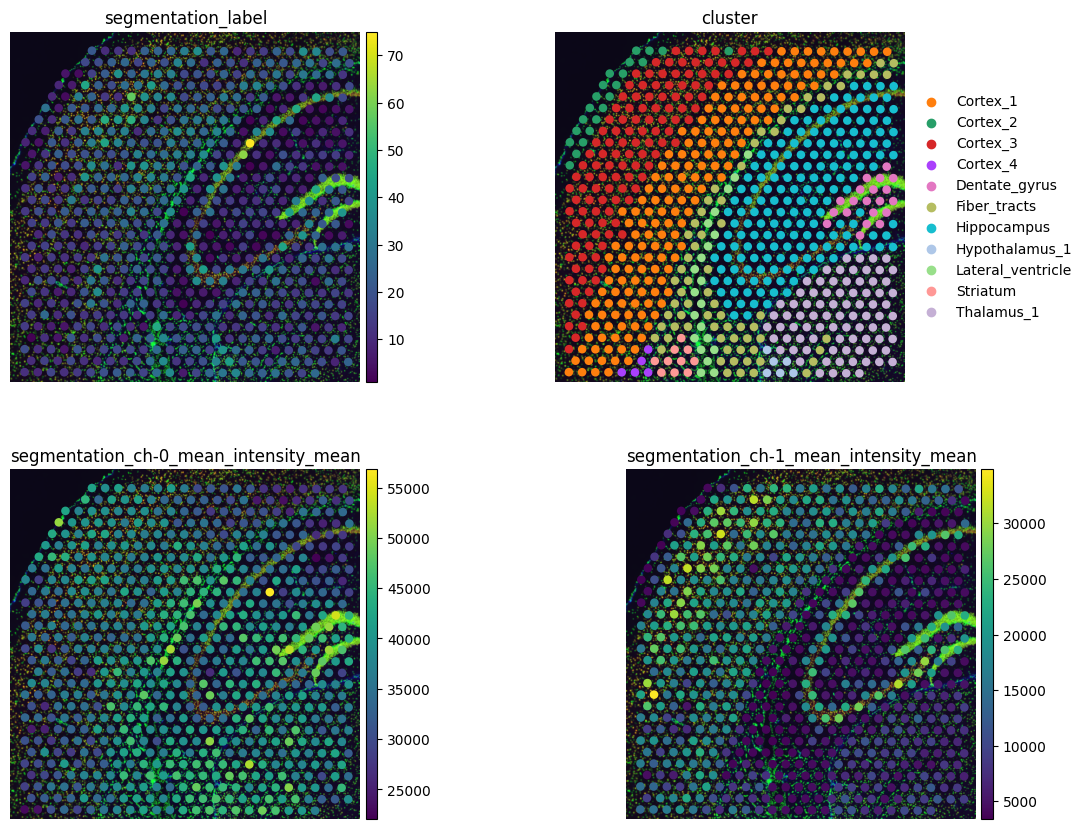

In [14]:
# plot results and compare with gene-space clustering
sq.pl.spatial_scatter(
    sq.pl.extract(adata, "features_segmentation"),
    color=[
        "segmentation_label",
        "cluster",
        "segmentation_ch-0_mean_intensity_mean",
        "segmentation_ch-1_mean_intensity_mean",
    ],
    frameon=False,
    ncols=2,
)

In [15]:
adata

AnnData object with n_obs × n_vars = 704 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'features_segmentation'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Above, we made use of `squidpy.pl.extract`, a method to extract all
features in a given [adata.obsm\[\'{key}\'\]]{.title-ref} and
temporarily save them to `anndata.AnnData.obs`. Such method is
particularly useful for plotting purpose, as shown above.

The number of cells per Visium spot provides an interesting view of the
data that can enhance the characterization of gene-space clusters. We
can see that the cell-rich pyramidal layer of the Hippocampus has more
cells than the surrounding areas (upper left). This fine-grained view of
the Hippocampus is not visible in the gene clusters where the
Hippocampus is one cluster only.

The per-channel intensities plotted in the second row show us that the
areas labeled with *Cortex_1* and *Cortex_3* have a higher intensity of
channel 1, *anti-NEUN* (lower left). This means that these areas have
more neurons that the remaining areas in this crop. In addition, cluster
*Fiber_tracts* and *lateral ventricles* seems to be enriched with *Glial
cells*, seen by the larger mean intensities of channel 2, *anti-GFAP*,
in these areas (lower right).

# Extract and cluster features

Now we will calculate summary, histogram, and texture features. These
features provide a useful compressed summary of the tissue image. For
more information on these features, refer to:

> -   `sphx_glr_auto_examples_image_compute_summary_features.py`.
> -   `sphx_glr_auto_examples_image_compute_histogram_features.py`.
> -   `sphx_glr_auto_examples_image_compute_texture_features.py`.


In [16]:
# define different feature calculation combinations
params = {
    # all features, corresponding only to tissue underneath spot
    "features_orig": {
        "features": ["summary", "texture", "histogram"],
        "scale": 1.0,
        "mask_circle": True,
    },
    # summary and histogram features with a bit more context, original resolution
    "features_context": {"features": ["summary", "histogram"], "scale": 1.0},
    # summary and histogram features with more context and at lower resolution
    "features_lowres": {"features": ["summary", "histogram"], "scale": 0.25},
}

for feature_name, cur_params in params.items():
    # features will be saved in `adata.obsm[feature_name]`
    sq.im.calculate_image_features(adata, img, layer="image", key_added=feature_name, n_jobs=8, **cur_params)

# combine features in one dataframe
adata.obsm["features"] = pd.concat([adata.obsm[f] for f in params.keys()], axis="columns")

# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

100%|███████████████| 704/704 [00:57<00:00, 12.29/s]


In [34]:
adata.obsm['features_orig']

histogram_ch-0_bin-0  histogram_ch-0_bin-1  \
AAACGAGACGGTTGAT-1                 27158                  1100   
AAAGGGATGTAGCAAG-1                 29686                   556   
AAATGGCATGTCTTGT-1                 25070                  2936   
AAATGGTCAATGTGCC-1                 26140                  1370   
AAATTAACGGGTAGCT-1                 28855                   832   
...                                  ...                   ...   
TTGTCGTTCAGTTACC-1                 17974                  1435   
TTGTGGCCCTGACAGT-1                 22507                  2954   
TTGTTAGCAAATTCGA-1                 22381                  3098   
TTGTTCAGTGTGCTAC-1                 31315                   187   
TTGTTGTGTGTCAAGA-1                 25045                  1982   

                    histogram_ch-0_bin-2  histogram_ch-0_bin-3  \
AAACGAGACGGTTGAT-1                   539                   500   
AAAGGGATGTAGCAAG-1                   268                   180   
AAATGGCATGTCTTGT-1                  1333                   789   
AAATGGTCAATGTGCC-1                  1131                  1047   
AAATTAACGGGTAGCT-1                   527                   325   
...                                  ...                   ...   
TTGTCGTTCAGTTACC-1                   693                   544   
TTGTGGCCCTGACAGT-1                  1888                  1332   
TTGTTAGCAAATTCGA-1                  1741                  1298   
TTGTTCAGTGTGCTAC-1                   109                    59   
TTGTTGTGTGTCAAGA-1                   963                   742   

                    histogram_ch-0_bin-4  histogram_ch-0_bin-5  \
AAACGAGACGGTTGAT-1                   407                   349   
AAAGGGATGTAGCAAG-1                   139                    99   
AAATGGCATGTCTTGT-1                   562                   367   
AAATGGTCAATGTGCC-1                   784                   610   
AAATTAACGGGTAGCT-1                   240                   314   
...                                  ...                   ...   
TTGTCGTTCAGTTACC-1                   522                   612   
TTGTGGCCCTGACAGT-1                  1052                   795   
TTGTTAGCAAATTCGA-1                  1067                   763   
TTGTTCAGTGTGCTAC-1                    45                    43   
TTGTTGTGTGTCAAGA-1                   717                   669   

                    histogram_ch-0_bin-6  histogram_ch-0_bin-7  \
AAACGAGACGGTTGAT-1                   330                   303   
AAAGGGATGTAGCAAG-1                    83                    99   
AAATGGCATGTCTTGT-1                   374                   388   
AAATGGTCAATGTGCC-1                   420                   305   
AAATTAACGGGTAGCT-1                   265                   168   
...                                  ...                   ...   
TTGTCGTTCAGTTACC-1                   627                   695   
TTGTGGCCCTGACAGT-1                   720                   372   
TTGTTAGCAAATTCGA-1                   676                   520   
TTGTTCAGTGTGCTAC-1                    31                    25   
TTGTTGTGTGTCAAGA-1                   634                   393   

                    histogram_ch-0_bin-8  histogram_ch-0_bin-9  ...  \
AAACGAGACGGTTGAT-1                   230                  1125  ...   
AAAGGGATGTAGCAAG-1                   106                   825  ...   
AAATGGCATGTCTTGT-1                   176                    46  ...   
AAATGGTCAATGTGCC-1                   163                    71  ...   
AAATTAACGGGTAGCT-1                    93                   422  ...   
...                                  ...                   ...  ...   
TTGTCGTTCAGTTACC-1                   824                  8115  ...   
TTGTGGCCCTGACAGT-1                   119                   302  ...   
TTGTTAGCAAATTCGA-1                   276                   221  ...   
TTGTTCAGTGTGCTAC-1                    56                   171  ...   
TTGTTGTGTGTCAAGA-1                   312                   584  ...

We can use the extracted image features to compute a new cluster
annotation. This could be useful to gain insights in similarities across
spots based on image morphology.

For this, we first define a helper function to cluster features.


In [23]:
def cluster_features(features: pd.DataFrame, like=None):
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]

Then, we calculate feature clusters using different features and compare
them to gene clusters:


/tmp/ipykernel_63255/1102943926.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)
/tmp/ipykernel_63255/1102943926.py:11: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)
/tmp/ipykernel_63255/1102943926.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)


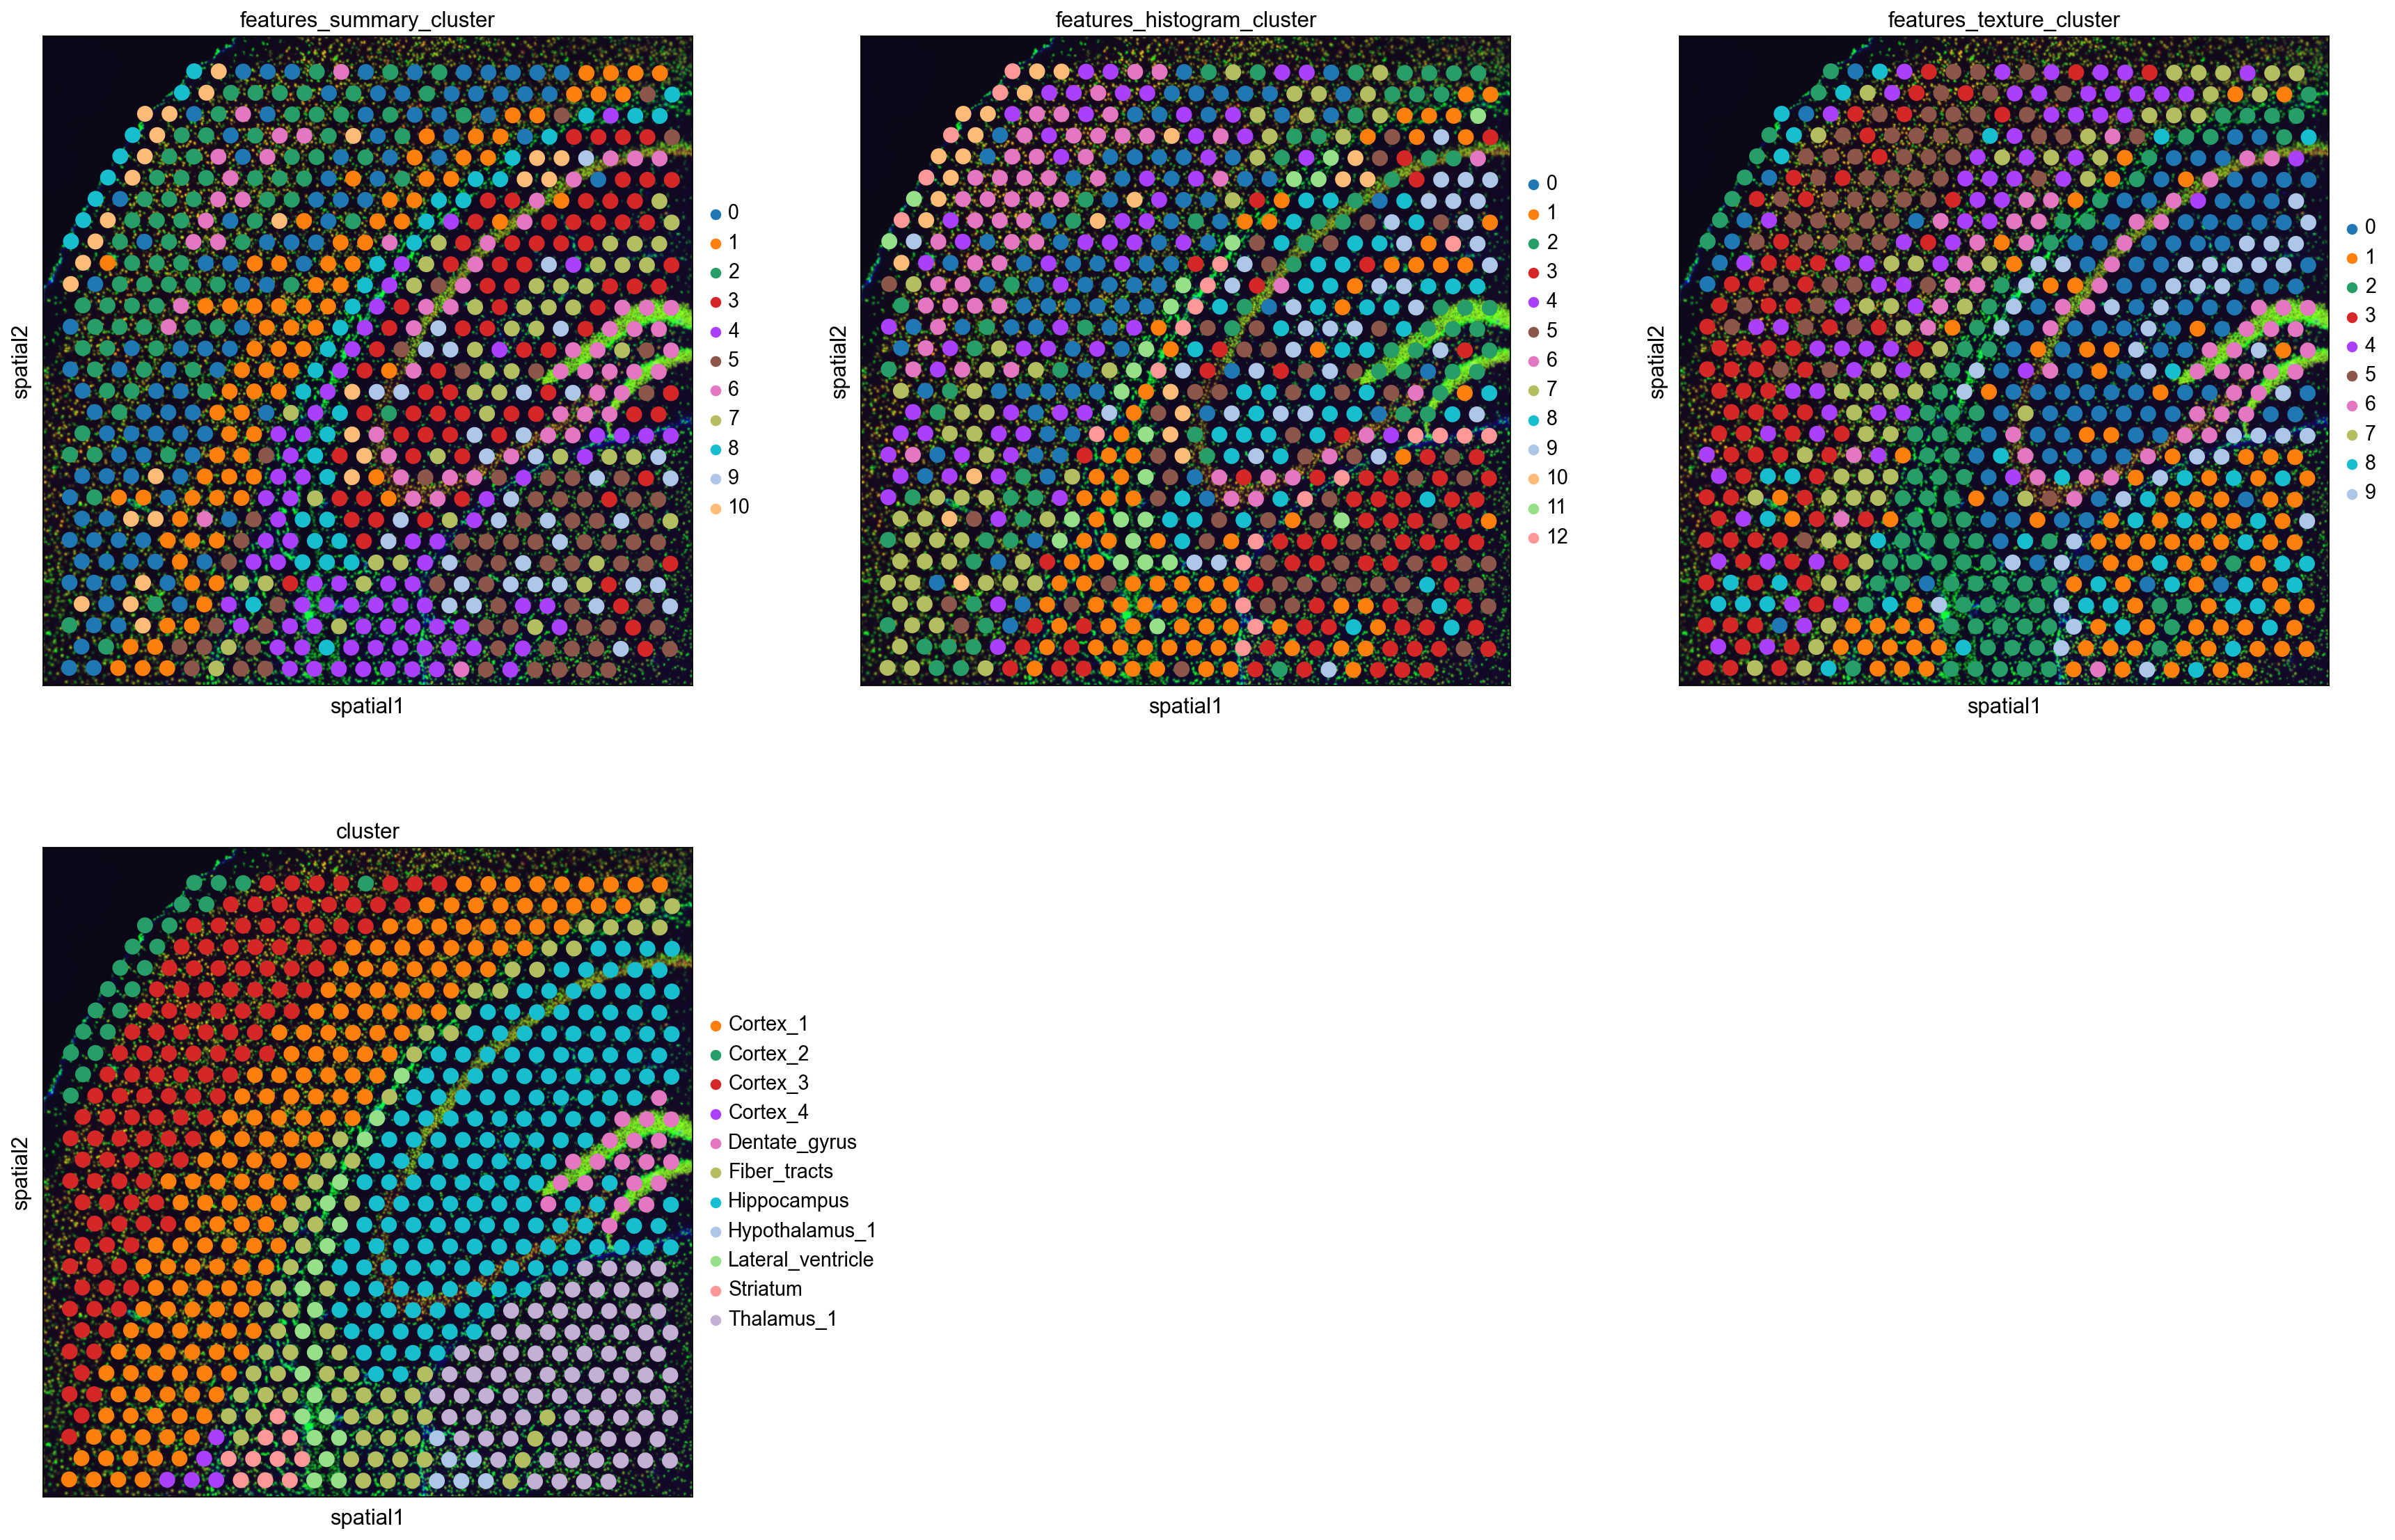

In [24]:
adata.obs["features_summary_cluster"] = cluster_features(adata.obsm["features"], like="summary")
adata.obs["features_histogram_cluster"] = cluster_features(adata.obsm["features"], like="histogram")
adata.obs["features_texture_cluster"] = cluster_features(adata.obsm["features"], like="texture")

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sq.pl.spatial_scatter(
    adata,
    color=[
        "features_summary_cluster",
        "features_histogram_cluster",
        "features_texture_cluster",
        "cluster",
    ],
    ncols=3,
)

Like the gene-space clusters (bottom middle), the feature space clusters
are also spatially coherent.

The feature clusters of the different feature extractors are quite
diverse, but all of them reflect the structure of the Hippocampus by
assigning different clusters to the different structural areas. This is
a higher level of detail than the gene-space clustering provides with
only one cluster for the Hippocampus.

The feature clusters also show the layered structure of the cortex, but
again subdividing it in more clusters than the gene-space clustering. It
might be possible to re-cluster the gene expression counts with a higher
resolution to also get more fine-grained clusters, but nevertheless the
image features seem to provide additional supporting information to the
gene-space clusters.
